# Causal Inference & Machine Learning - From Matching to Meta-Learners

### Loading Libraries

In [80]:
# Numerical Computing
import numpy as np

# Data Manipulation
import pandas as pd

# IterTools
from itertools import combinations

# Statistical Models
from scipy import stats
import statsmodels.api as sm

# Networkx
import networkx as nx

# JavaScript Object Notation
import json

# Data Visualization
import graphviz
import seaborn as sns
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.metrics import mean_absolute_percentage_error

# DoWhy Causal Libraries
import dowhy
from dowhy import gcm
from dowhy import CausalModel
from dowhy.causal_model import CausalModel

# Notebook Iteration 
from tqdm import tqdm

# Copy
from copy import deepcopy

# Light Gradient Boosting Models
from lightgbm import LGBMRegressor, LGBMClassifier

In [75]:
help(CausalModel)

Help on class CausalModel in module dowhy.causal_model:

class CausalModel(builtins.object)
 |  CausalModel(data, treatment, outcome, graph=None, common_causes=None, instruments=None, effect_modifiers=None, estimand_type='nonparametric-ate', proceed_when_unidentifiable=False, missing_nodes_as_confounders=False, identify_vars=False, **kwargs)
 |  
 |  Main class for storing the causal model state.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, data, treatment, outcome, graph=None, common_causes=None, instruments=None, effect_modifiers=None, estimand_type='nonparametric-ate', proceed_when_unidentifiable=False, missing_nodes_as_confounders=False, identify_vars=False, **kwargs)
 |      Initialize data and create a causal graph instance.
 |      
 |      Assigns treatment and outcome variables.
 |      Also checks and finds the common causes and instruments for treatment
 |      and outcome.
 |      
 |      At least one of graph, common_causes or instruments must be provided. If
 |

### Setting Color & Viz Parameters

In [2]:
COLORS = [
    '#069AF3',
    '#F97306'
]

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
dowhy.__version__

'0.11.1'

### Matching

In [5]:
earnings_data = pd.read_csv('/Users/isisromero/desktop/causal_inference/data/ml_earnings.csv')

In [6]:
earnings_data.shape

In [7]:
earnings_data.head()

,age,took_a_course,earnings
0,19,False,110579.0
1,28,False,142577.0
2,22,True,130520.0
3,25,True,142687.0
4,24,False,127832.0


In [8]:
earnings_data.groupby(['age', 'took_a_course']).mean()

earnings
age took_a_course               
19  False          111110.875000
    True           123488.000000
20  False          115227.142857
    True           125633.285714
21  False          117114.900000
    True           130155.000000
22  False          120226.363636
    True           131437.222222
23  False          124460.900000
    True           134654.333333
24  False          126878.583333
    True           137564.250000
25  False          130812.800000
    True           142715.000000
26  False          134004.250000
    True           144552.800000
27  False          139035.600000
    True           148744.333333
28  False          141580.000000
    True           152485.333333
29  False          145248.600000
    True           152694.000000
30  False          150333.750000
    True           159586.400000
31  False          152532.000000
    True           163592.000000
32  False          157515.200000
    True           169854.000000
33  False          162453.500000
    True           170020.000000
34  False          165694.200000
    True           178922.000000
35  False          172134.250000
    True           180404.500000
36  False          175240.666667
37  False          181514.000000
    True           187627.000000
38  False          185546.333333
39  False          187253.666667
41  False          201729.000000
    True           207676.000000
42  False          203029.000000
    True           214445.000000
43  False          210243.000000
45  True           233035.000000
48  False          239510.000000

In [9]:
# Compute Naïve Estimate 
treatment_avg = earnings_data.query('took_a_course==1')['earnings'].mean()
cntrl_avg = earnings_data.query('took_a_course==0')['earnings'].mean()

treatment_avg - cntrl_avg

#### Define The Graph

In [10]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['took_a_course', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

In [11]:
# Instantiate The CausalModel 
model = CausalModel(
    data=earnings_data,
    treatment='took_a_course',
    outcome='earnings',
    graph=gml_string
)

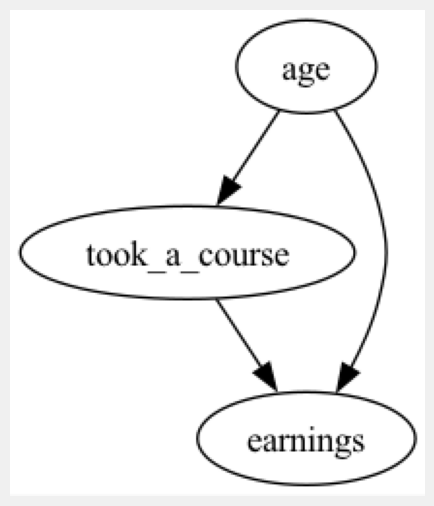

In [12]:
model.view_model()

#### Getting The Estimand

In [13]:
# Get The Estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



#### Estimate The Effect

In [14]:
# Get Estimate (Matching)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.distance_matching',
    target_units='ate',
    method_params={'distance_metric': 'minkowski', 'p': 2})

In [15]:
estimate.value

In [16]:
refutation = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='random_common_cause')

In [17]:
print(refutation)

### S-Learner: The Lone Ranger

In [18]:
def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(5000, 22000)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(np.sort(effect_true), np.sort(effect_true), color=COLORS[1], alpha=.7, label='Perfect model')
    plt.xlabel('$True\ effect$', fontsize=14, alpha=.5)
    plt.ylabel('$Predicted\ effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

#### Read The Data

In [19]:
# Train set
earnings_interaction_train = pd.read_csv('/Users/isisromero/desktop/causal_inference/data/ml_earnings_interaction_train.csv')

# Test set
earnings_interaction_test = pd.read_csv('/Users/isisromero/desktop/causal_inference/data/ml_earnings_interaction_test.csv')

In [22]:
earnings_interaction_train.shape, earnings_interaction_test.shape

In [23]:
# Train 
earnings_interaction_train.head()

,age,python_proficiency,took_a_course,earnings
0,23,0.632318,True,139267.0
1,20,0.602551,False,115569.0
2,21,0.518225,False,119142.0
3,25,0.945161,False,130291.0
4,30,0.636251,True,164209.0


In [24]:
# Test
earnings_interaction_test.head()

,age,python_proficiency,took_a_course,true_effect
0,30,0.223877,True,11120.0
1,23,0.394152,True,11970.0
2,37,0.214638,True,11073.0
3,21,0.869069,True,14345.0
4,41,0.833934,True,14169.0


#### Define The Graph

In [25]:
# Construct the graph (the graph is constant for all iterations)
nodes = ['took_a_course', 'python_proficiency', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings'),
    ('python_proficiency', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'
    
gml_string += ']'

In [26]:
# Instantiate the CausalModel 
model = CausalModel(
    data=earnings_interaction_train,
    treatment='took_a_course',
    outcome='earnings',
    effect_modifiers='python_proficiency',
    graph=gml_string
)

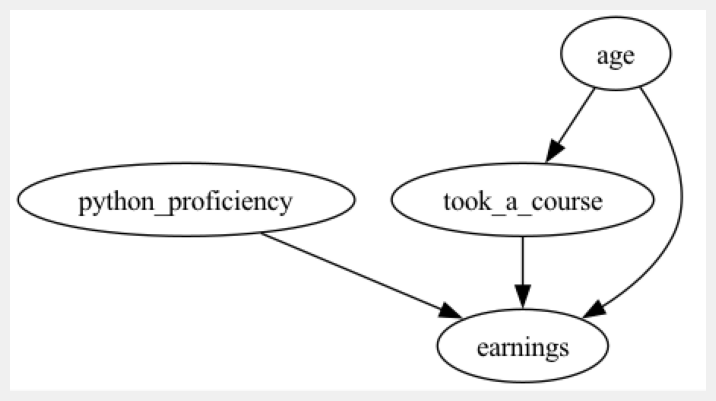

In [27]:
model.view_model()

#### Getting The Estimand

In [28]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [29]:
# Get estimate (S-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.SLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'overall_model': LGBMRegressor(n_estimators=500, max_depth=10)
        },
        'fit_params': {}
    })

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [30]:
estimate.cate_estimates.mean()

#### Refuting

In [31]:
refutation = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='random_common_cause')

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000086 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000118 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000037 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000062 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train se

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000032 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000034 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000035 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 547
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 5
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [32]:
print(refutation)

Refute: Add a random common cause
Estimated effect:12547.068205674783
New effect:12545.97003130999
p value:0.9199999999999999



In [34]:
refutation = model.refute_estimate(
    estimand=estimand, 
    estimate=estimate,
    method_name='placebo_treatment_refuter')

print(refutation)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000040 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000072 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000024 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000074 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000067 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000050 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000023 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000081 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000031 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000030 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000018 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000028 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000026 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000019 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000022 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000020 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000027 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000029 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 292
[LightGBM] [Info] Number of data points in the train set: 5000, number of used features: 4
[LightGBM] [Info] Start training from score 143134.027200
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gai

In [35]:
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:12547.068205674783
New effect:22.864769121223503
p value:0.8400000000000001



#### Test Data Predictions

In [37]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [38]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

In [39]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

#### What happens when your dataset is small?

In [40]:
# Instantiate the CausalModel 
model_small = CausalModel(
    data=earnings_interaction_train.sample(100),
    treatment='took_a_course',
    outcome='earnings',
    effect_modifiers='python_proficiency',
    graph=gml_string
)

In [49]:
# Get estimate (S-Learner)
estimate = model_small.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.SLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'overall_model': LGBMRegressor(n_estimators=500, max_depth=10)
        },
        'fit_params': {}
    })

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 58
[LightGBM] [Info] Number of data points in the train set: 100, number of used features: 4
[LightGBM] [Info] Start training from score 141389.500000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [42]:
# Compute predictions
effect_pred = model_small.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [43]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

In [44]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

### T-Learner: Together We Can Do More

#### Estimate the effect

In [45]:
# Get estimate (T-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.TLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': [
                LGBMRegressor(n_estimators=200, max_depth=10),
                LGBMRegressor(n_estimators=200, max_depth=10)
            ]
        },
        'fit_params': {}
    })

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 3031, number of used features: 2
[LightGBM] [Info] Start training from score 141133.240845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [46]:
estimate.cate_estimates.mean()

#### Test Data Prediction

In [48]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [49]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

In [50]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

### X-Learner: A Step Further

#### Estimate The Effect

In [51]:
# Get estimate (X-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.XLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': [
                LGBMRegressor(n_estimators=50, max_depth=10),
                LGBMRegressor(n_estimators=50, max_depth=10)
            ],
            'cate_models': [
                LGBMRegressor(n_estimators=50, max_depth=10),
                LGBMRegressor(n_estimators=50, max_depth=10)
            ]
        },
        'fit_params': {},
    })

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 3031, number of used features: 2
[LightGBM] [Info] Start training from score 141133.240845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000038 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Number of data points in the train set: 1969, number of used features: 2
[LightGBM] [Info] Start training from score 146213.957847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000049 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] 

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [52]:
# X-Learner with just one specified model - equivalent to the cell above
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.XLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': LGBMRegressor(n_estimators=50, max_depth=10),
        },
        'fit_params': {},
    })

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in the train set: 3031, number of used features: 2
[LightGBM] [Info] Start training from score 141133.240845
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 285
[LightGBM] [Info] Number of data points in the train set: 1969, number of used features: 2
[LightGBM] [Info] Start training from score 146213.957847
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 287
[LightGBM] [Info] Number of data points in

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [53]:
estimate.cate_estimates.mean()

#### Test Data Prediction (2)

In [55]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [56]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

In [57]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

#### X-Learner on Small Data

In [58]:
# Get estimate (X-Learner)
estimate = model_small.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.XLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': LGBMRegressor(n_estimators=50, max_depth=10)
        },
        'fit_params': {}
    })

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33
[LightGBM] [Info] Number of data points in the train set: 52, number of used features: 2
[LightGBM] [Info] Start training from score 146235.288462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [59]:
# Compute predictions
effect_pred = model_small.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [60]:
# Compute the error 
mean_absolute_percentage_error(effect_true, effect_pred)

In [61]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

### Meta-Learners on Experiental Data (Kevin Hillstrom)

In [67]:
# Read in the data
hillstrom_clean = pd.read_csv('/Users/isisromero/desktop/causal_inference/data/hillstrom_clean.csv')

# Read in labels mapping
with open('/Users/isisromero/desktop/causal_inference/data/hillstrom_clean_label_mapping.json', 'r') as f:
    hillstrom_labels_mapping = json.load(f)

In [68]:
hillstrom_clean.head()

,recency,history,mens,womens,newbie,visit,conversion,spend,zip_code__rural,zip_code__surburban,zip_code__urban,channel__multichannel,channel__phone,channel__web,treatment
0,10,142.44,1,0,0,0,0,0.0,0,1,0,0,1,0,1
1,6,329.08,1,1,1,0,0,0.0,1,0,0,0,0,1,0
2,7,180.65,0,1,1,0,0,0.0,0,1,0,0,0,1,1
3,9,675.83,1,0,1,0,0,0.0,1,0,0,0,0,1,2
4,2,45.34,1,0,0,0,0,0.0,0,0,1,0,0,1,1


In [69]:
hillstrom_clean.columns

Index(['recency', 'history', 'mens', 'womens', 'newbie', 'visit', 'conversion',
       'spend', 'zip_code__rural', 'zip_code__surburban', 'zip_code__urban',
       'channel__multichannel', 'channel__phone', 'channel__web', 'treatment'],
      dtype='object')

### Doubly Robust Methods: Let’s Get More!

#### Estimating The Effect

In [76]:
# Get estimate (Doubly robust)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dr.DRLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'model_propensity': LogisticRegression(),
            'model_regression': LGBMRegressor(n_estimators=1000, max_depth=10)
        },
        'fit_params': {}
    }
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 289
[LightGBM] [Info] Number of data points in the train set: 2500, number of used features: 3
[LightGBM] [Info] Start training from score 142618.728000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gai

In [71]:
estimate.cate_estimates.mean()

#### Test Data Prediction

In [78]:
# Compute predictions
causal_estimator = estimate.estimator

effect_pred = causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

In [82]:
# Compute the error 
# mean_absolute_percentage_error(effect_true, effect_pred)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [84]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

### If Machine Learning is Cool, How About Double Machine Learning?

#### Estimating The Effect

In [85]:
# Get estimate (DML)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dml.LinearDML',
    target_units='ate',
    method_params={
        'init_params': {
            'model_y': LGBMRegressor(n_estimators=500, max_depth=10),
            'model_t': LGBMRegressor(n_estimators=500, max_depth=10),
        },
        'fit_params': {}
    })

In [86]:
estimate.cate_estimates.mean()

#### Test Data Prediction

In [87]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [88]:
# # Compute the error 
# mean_absolute_percentage_error(effect_true, effect_pred)

In [89]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

### Matching in the Wild - Simulation

#### Probability of Finding at Least One Match per Row

In [90]:
results_per_dimension = {}

for d in range(2, 19):
    results = []
    
    N_SAMPLES = 1000
    DIM_X = d

    for i in tqdm(range(100)):

        X = np.random.binomial(n=1, p=.5, size=(N_SAMPLES, DIM_X))

        local_results = []

        for row in range(X.shape[0]):
            # Did we find at least 1 match for `row`?
            success = (np.where(np.where(X == X[row], 1, 0).sum(axis=1) == DIM_X, 1, 0).sum() - 1) > 0
            local_results.append(success)

        results.append(np.array(local_results).mean())
        
    results_per_dimension[d] = results

In [91]:
# Compute statistics
mean_p = pd.DataFrame(results_per_dimension).mean(axis=0).values
sd_p = pd.DataFrame(results_per_dimension).std(axis=0).values

In [92]:
# Plot
plt.figure(figsize=(12, 8))
plt.fill_between(range(2, 19), mean_p - sd_p*2, mean_p + sd_p*2, color=COLORS[0], alpha=.2, label='$+/-2SD$')
plt.plot(range(2, 19), mean_p, color=COLORS[0], lw=2, label='$\mu$')
plt.legend()
plt.xlabel('$Dimensionalty \ of \ X$', alpha=.5)
plt.ylabel('$Probability \ of \ finding \ at \ least \ one \ match$', alpha=.5)
plt.show()